# AI4 Cancer Research - Spotlight: ATHENA

In this tutorial we will showcase how ATHENA can be used to explore Imaging Mass Cytometry datasets. We will use the publicly available dataset of (Jackson et al., 2020 - [paper](https://www.nature.com/articles/s41586-019-1876-x)), where the authors used a panel of 35 cancer and immune markers to spatially profile the breast cancer ecosystem using Tissue Microarrays (TMAs) from two cohorts of breast cancer patients. 

## Scores

ATHENA implements two flavors of the scores, a global one that returns an estimate at the whole-sample level, and a local one, where, for each cell in the sample, the score is computed on the sub-graph only containing all direct neighbors of this cell.

### Sample-level scores (global)
Sample-level scores ignore the spatial topology (cell-cell interactions) and estimate a single score for the whole tumor, saved in `so.spl`. 

### Cell-level scores (local)
Cell-level scores quantify heterogeneity in a spatial manner, accounting for local effects, and return a value per single cell, saved in `so.obs`. To apply these scores to the data we provide the argument `local=True`.  Since these scores heavily depend on the tumor topology, the graph type and occasionally additional parameters also need to be provided.


## Resources
- ATHENA: analysis of tumor heterogeneity from spatial omics measurements, [Bioinformatics](https://doi.org/10.1093/bioinformatics/btac303)
- [GitHub](https://github.com/AI4SCR/ATHENA)

## Installation
Please follow the instructions in the [documentation](https://ai4scr.github.io/ATHENA/source/installation.html).

## Setup Workspace

In [1]:
import athena as ath
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
import pickle
from pathlib import Path

cores_modularity = ['SP43_75_X2Y5','SP41_191_X15Y7']
cores_entropy = ['SP43_75_X2Y5', 'slide_49_By2x5', 'SP41_239_X11Y3_165']
cores_entropy_global = ['slide_7_Cy2x4']
cores_infiltration = ['SP43_116_X3Y4', 'SP41_220_X10Y5', 'SP41_191_X15Y7']

cores = set([*cores_entropy, *cores_modularity, *cores_infiltration, *cores_entropy_global])

ath.__version__

'0.1.2'

## Load IMC data into a `SpatialOmics` object
Although the dataset consists of a total of 720 tumor images from 352 patients with breast cancer, for this tutorial, we will work with
7 selected TMA cores that can be easily loaded using the `.dataset` module of `Athena`:

Note: Download the latest version of the data set by setting `force_download=True`

In [2]:
so = ath.dataset.imc_sample()
so


SpatialOmics object with n_obs 22839
    X: 7, (1541, 6069) x (34, 34)
    spl: 7, ['pid', 'location', 'grade', 'tumor_type', 'age', 'Subtype', 'cell_count', 'immune_cell_count', 'infiltration_radius', 'richness_meta_id', 'shannon_meta_id', 'quadratic_meta_id', 'modularity_meta_id_res1', 'modularity_cell_type_id_res1']
    obs: 7, {'CellId', 'shannon_meta_id_contact', 'quadratic_meta_id_contact', 'infiltration_radius', 'meta_id', 'core', 'cell_type_id', 'x', 'tumor_immune', 'id', 'richness_meta_id_contact', 'meta_label', 'cell_type', 'phenograph_cluster', 'tumor_immune_id', 'y'}
    var: 7, {'feature_type', 'metal_tag', 'fullstack_index', 'channel', 'full_target_name', 'target'}
    G: 7, {'radius', 'knn', 'contact'}
    masks: 7, {'cellmasks'}
    images: 7

In [14]:
for spl in so.obs.keys():
    so.obs[spl].index = so.obs[spl].index.astype(int)

In [6]:
# with open(Path('~/Downloads/final_pop.pkl').expanduser(), 'rb') as f:
#     so = pickle.load(f)
# so

## Explore `SpatialOmics` object

Various preprocessing steps (segmentation, single-cell quantification, phenotyping) have been applied to the data by the original authors and are included in the various attributes of the data. For example, `so.spl` contains sample-level metadata:

In [4]:
print(so.spl.columns.values) #see all available sample annotations

['pid' 'fullstack_file' 'cellmask_file' 'location' 'grade' 'tumor_type'
 'tumor_size' 'gender' 'menopausal' 'PTNM_M' 'age' 'Patientstatus'
 'treatment' 'PTNM_T' 'DiseaseStage' 'PTNM_N' 'AllSamplesSVSp4.Array'
 'TMALocation' 'TMAxlocation' 'yLocation' 'DonorBlocklabel'
 'diseasestatus' 'TMABlocklabel' 'UBTMAlocation' 'SupplierPatientID'
 'Yearofsamplecollection' 'PrimarySite' 'histology' 'PTNM_Radicality'
 'Lymphaticinvasion' 'Venousinvasion' 'ERStatus' 'PRStatus' 'HER2Status'
 'Pre-surgeryTx' 'Post-surgeryTx' 'Tag' 'Ptdiagnosis' 'DFSmonth' 'OSmonth'
 'Comment' 'ER+DuctalCa' 'TripleNegDuctal' 'hormonesensitive'
 'hormonerefractory' 'hormoneresistantaftersenstive' 'Fulvestran'
 'microinvasion' 'I_plus_neg' 'SN' 'MIC' 'Count_Cells' 'Height_FullStack'
 'Width_FullStack' 'area' 'Subtype' 'HER2' 'ER' 'PR' 'clinical_type'
 'cell_count' 'immune_cell_count' 'infiltration_radius' 'richness_meta_id'
 'shannon_meta_id' 'quadratic_meta_id' 'modularity_meta_id_res1'
 'modularity_cell_type_id_res1']


In [5]:
so.spl.head(3) 

pid                                     fullstack_file  \
core                                                                         
slide_49_By2x5       49                                                NaN   
SP41_191_X15Y7      191  /Users/art/Library/CloudStorage/Box-Box/docume...   
SP41_239_X11Y3_165  239  /Users/art/Library/CloudStorage/Box-Box/docume...   

                                                        cellmask_file  \
core                                                                    
slide_49_By2x5                                                    NaN   
SP41_191_X15Y7      /Users/art/Library/CloudStorage/Box-Box/docume...   
SP41_239_X11Y3_165  /Users/art/Library/CloudStorage/Box-Box/docume...   

                   location grade       tumor_type  tumor_size  gender  \
core                                                                     
slide_49_By2x5       CENTER     2  INVASIVE_DUCTAL        48.0  FEMALE   
SP41_191_X15Y7          NaN   NaN              NaN         NaN     NaN   
SP41_239_X11Y3_165      NaN   NaN              NaN         NaN     NaN   

                   menopausal PTNM_M  ...   PR clinical_type cell_count  \
core                                  ...                                 
slide_49_By2x5           POST     M0  ...    +      HR+HER2-       1541   
SP41_191_X15Y7            NaN    NaN  ...  NaN           NaN       4544   
SP41_239_X11Y3_165        NaN    NaN  ...  NaN           NaN       2734   

                   immune_cell_count infiltration_radius richness_meta_id  \
core                                                                        
slide_49_By2x5                   444            0.441435             19.0   
SP41_191_X15Y7                   779            2.054326             18.0   
SP41_239_X11Y3_165               412            1.120000             21.0   

                    shannon_meta_id  quadratic_meta_id  \
core                                                     
slide_49_By2x5             3.333942           0.949542   
SP41_191_X15Y7             1.630264           0.534260   
SP41_239_X11Y3_165         3.220446           0.878209   

                    modularity_meta_id_res1  modularity_cell_type_id_res1  
core                                                                       
slide_49_By2x5                     0.469206                      0.463629  
SP41_191_X15Y7                     0.173872                      0.161312  
SP41_239_X11Y3_165                 0.394017                      0.339262  

[3 rows x 68 columns]

... and `so.obs` contains all single-cell level metadata:

In [6]:
spl = 'slide_49_By2x5' #for one specific sample
so.obs[spl].columns.values #see all available sample annotations

array(['core', 'meta_id', 'meta_label', 'cell_type_id', 'cell_type',
       'phenograph_cluster', 'CellId', 'id', 'tumor_immune_id',
       'tumor_immune', 'y', 'x', 'infiltration_radius',
       'richness_meta_id_contact', 'shannon_meta_id_contact',
       'quadratic_meta_id_contact'], dtype=object)

In [7]:
so.obs[spl].head(3) 

core meta_id      meta_label cell_type_id cell_type  \
1  slide_49_By2x5      11  Fibronectin Hi            3   stromal   
2  slide_49_By2x5      11  Fibronectin Hi            3   stromal   
3  slide_49_By2x5      11  Fibronectin Hi            3   stromal   

  phenograph_cluster  CellId                        id tumor_immune_id  \
1                  2       1  ZTMA208_slide_49_By2x5_1               3   
2                  2       2  ZTMA208_slide_49_By2x5_2               3   
3                  2       3  ZTMA208_slide_49_By2x5_3               3   

  tumor_immune         y           x  infiltration_radius  \
1        other  0.800000  134.100000                  0.0   
2        other  1.568966  249.137931                  0.0   
3        other  2.000000  276.809524                  0.0   

   richness_meta_id_contact  shannon_meta_id_contact  \
1                         1                     -0.0   
2                         1                     -0.0   
3                         1                     -0.0   

   quadratic_meta_id_contact  
1               1.110223e-16  
2               1.110223e-16  
3               1.110223e-16

The `so.mask` attribute can store for each sample different segmentation masks. For this data set we have access to the segmentation into single cells (`cellmasks`).

In [8]:
print(so.masks[spl].keys())

dict_keys(['cellmasks'])


## Visualize raw images and masks
Run the cell below to launch the interactive [napari](https://napari.org) viewer and explore the multiplexed raw images. In addition to the single protein expression levels, we also add segmentations masks (with `add_masks`) for the single-cells.

In [9]:
ath.pl.napari_viewer(so, spl, attrs=['DNA2', 'H3'], add_masks=so.masks[spl].keys())

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


## Visualize single-cell data

### Plot protein intensity or single-cell annotations 

Samples stored in the `SpatialOmics` object can be visualised with the plotting function `pl.spatial`.
In a first step we extract the centroids of each cell segmentation masks with `pp.extract_centroids` and store the results in the `SpatialOmics` instance (`so.obs[spl]`). This is required to enable the full plotting functionalities.

In [10]:
# extract cell centroids across all samples
for spl in cores:
    ath.pp.extract_centroids(so, spl, mask_key='cellmasks')

# print results
so.obs[spl][['x','y']].head()

x         y
1   31.977273  1.272727
2   53.843137  1.470588
3   70.487805  3.036585
4   96.526316  1.078947
5  130.218750  1.250000

If only the `SpatialOmics` instance and the sample id is provided, the sample is plotted as a scatter plot using the computed centroids. However, with `mode=mask`, the computed segmentation masks are used. The observations can be colored according to a specific feature from `so.obs[spl]` or `so.X[spl]` - see example below.

Note: When plotting with `mode='mask'` the plotted feature needs to be numeric.

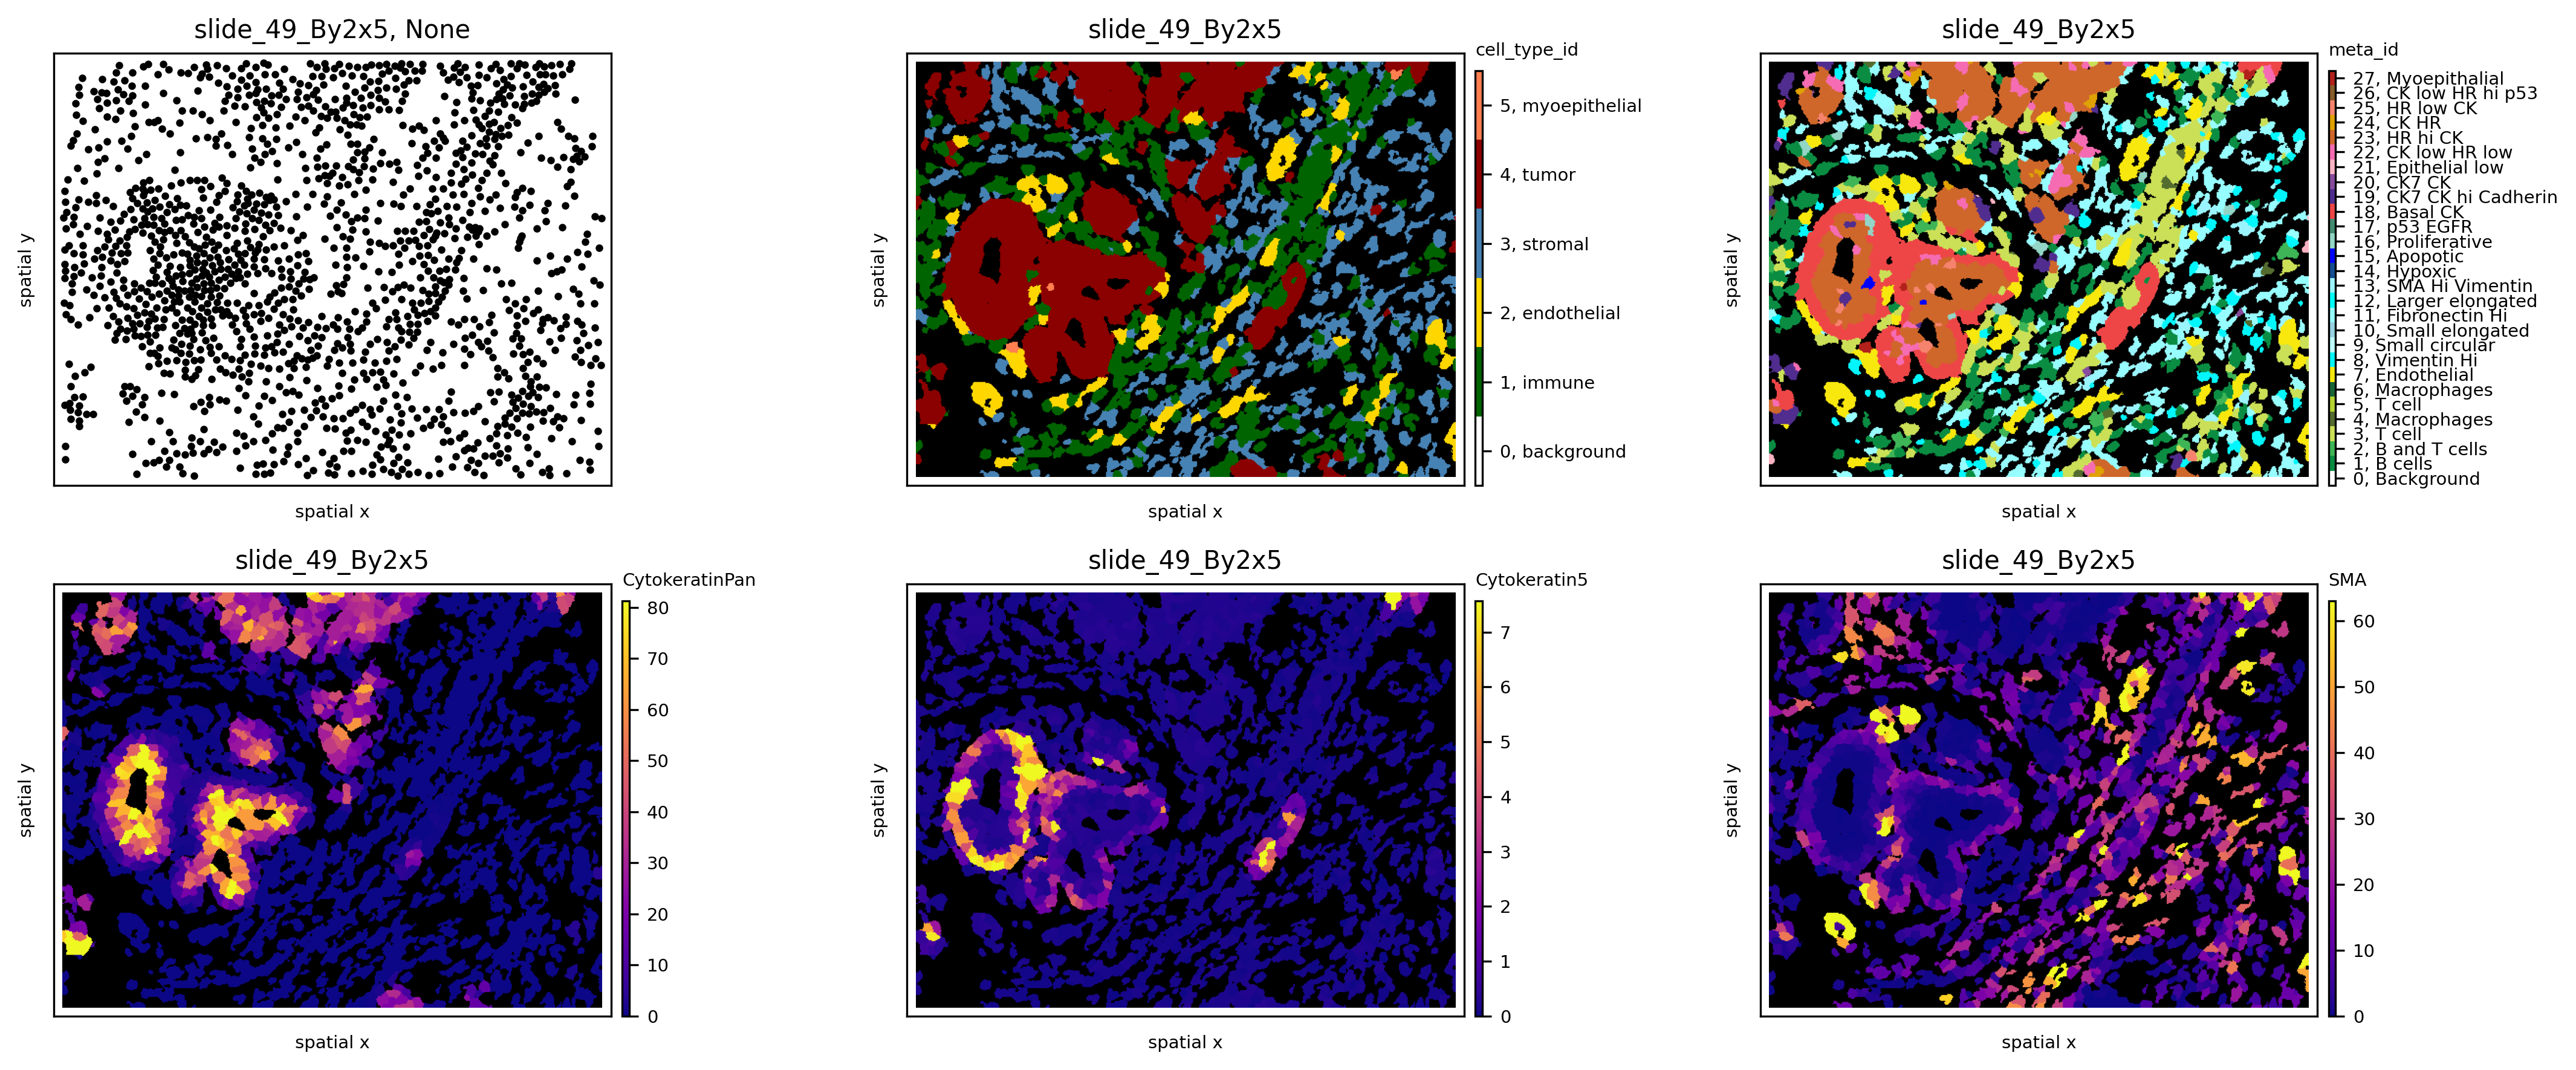

In [21]:
spl = 'slide_49_By2x5'
fig, axs = plt.subplots(2, 3, figsize=(15, 6), dpi=300)
ath.pl.spatial(so, spl, None, ax=axs.flat[0])
ath.pl.spatial(so, spl, 'cell_type_id', mode='mask', ax=axs.flat[1], background_color='black')
ath.pl.spatial(so, spl, 'meta_id', mode='mask', ax=axs.flat[2], background_color='black')
ath.pl.spatial(so, spl, 'CytokeratinPan', mode='mask', ax=axs.flat[3], background_color='black')
ath.pl.spatial(so, spl, 'Cytokeratin5', mode='mask', ax=axs.flat[4], background_color='black')
ath.pl.spatial(so, spl, 'SMA', mode='mask', ax=axs.flat[5], background_color='black')

## Graph construction
Use the `.graph` submodule to construct 3 different graphs and experiment with the parameters (k, radius):

In [12]:
# import default graph builder parameters
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

# kNN graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
config['builder_params']['n_neighbors'] = 6 # set parameter k
ath.graph.build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config)

# radius graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
config['builder_params']['radius'] = 20 # set radius
ath.graph.build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

# contact graph - this takes some time
ath.graph.build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

# the results are saved back into `.G`:
so.G[spl]

100%|██████████████████████████████████████████████████████████| 1541/1541 [00:12<00:00, 120.02it/s]


{'radius': <networkx.classes.graph.Graph at 0x7fb00c8bc6d0>,
 'knn': <networkx.classes.graph.Graph at 0x7fb00c8c4520>,
 'contact': <networkx.classes.graph.Graph at 0x7fafe9a14b20>}

The results can be plotted again using the `pl.spatial` submodule. Notice how different graph builders result in graphs with different properties:

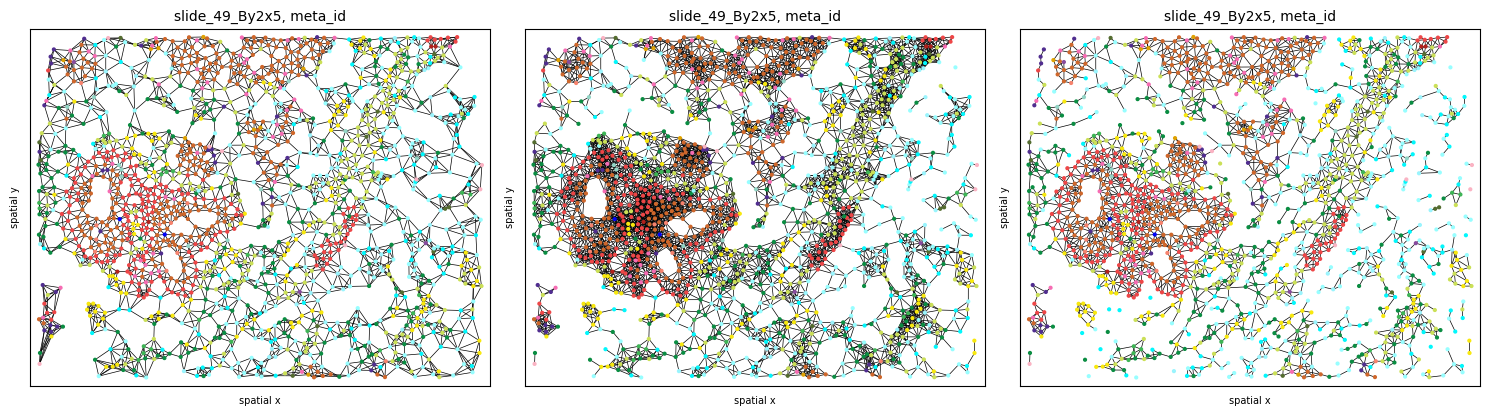

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)
ath.pl.spatial(so, spl, 'meta_id', edges=True, graph_key='knn', ax=axs.flat[0], cbar=False)
ath.pl.spatial(so, spl, 'meta_id', edges=True, graph_key='radius', ax=axs.flat[1], cbar=False)
ath.pl.spatial(so, spl, 'meta_id', edges=True, graph_key='contact', ax=axs.flat[2], cbar=False)

## Modularity

In [14]:
attr = 'meta_id'
for spl in cores_modularity:
    ath.metrics.modularity(so, spl, attr, graph_key='contact')

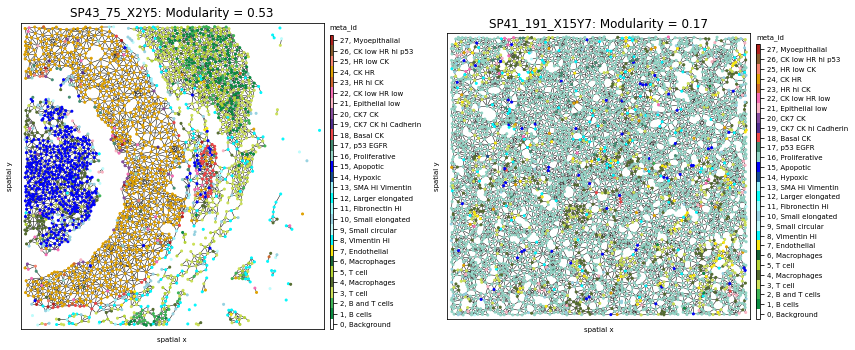

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for ax, spl in zip(axs, cores_modularity):
    score = so.spl.loc[spl][f'modularity_{attr}_res1']
    ath.pl.spatial(so, spl, attr, edges=True, ax=ax, graph_key='contact')
    ax.set_title(f'{spl}: Modularity = {score:.2f}')

## Heterogeneity quantification

### Sample-level scores
In the following section we compute the shannon entorpy for the sampls. We observe how the shannon entropy is very similar even though the spatial organisation of the tissue is very different.

In [16]:
# compute cell counts
so.spl['cell_count'] = [len(so.obs[s]) for s in so.obs.keys()]
so.spl['immune_cell_count'] = [np.sum(so.obs[s].cell_type == 'immune') for s in so.obs.keys()]

# compute metrics at a sample level
for s in cores_entropy:
    ath.metrics.richness(so, s, 'meta_id', local=False)
    ath.metrics.shannon(so, s, 'meta_id', local=False)
    ath.metrics.quadratic_entropy(so, spl, 'meta_id', local=False, graph_key='contact', metric='cosine')

# estimated values are saved in so.spl    
so.spl.loc[cores_entropy, ['cell_count', 'richness_meta_id', 'shannon_meta_id']]

cell_count  richness_meta_id  shannon_meta_id
core                                                             
SP43_75_X2Y5              2771              25.0         3.311329
slide_49_By2x5            1541              19.0         3.333942
SP41_239_X11Y3_165        2734              21.0         3.220446

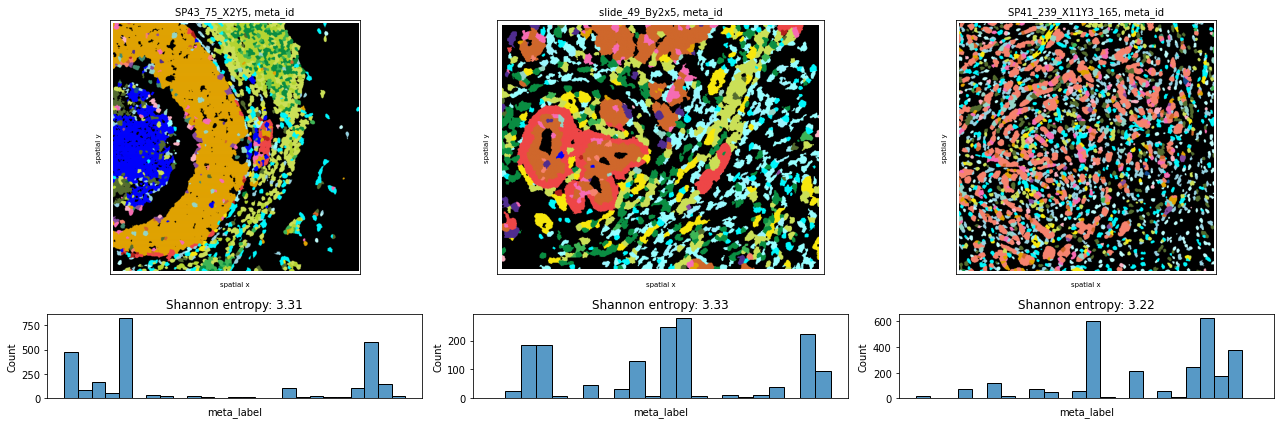

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(18, 6), gridspec_kw={'height_ratios': [3,1]})
for axv, spl in zip(axs.T, cores_entropy):
    ath.pl.spatial(so, spl, 'meta_id', mode='mask', ax=axv[0], cbar=False, background_color='black')
    sns.histplot(so.obs[spl]['meta_label'], ax=axv[1])
    axv[1].set_title(f'Shannon entropy: {so.spl.loc[spl].shannon_meta_id:.2f}')
    axv[1].set_xticks([])

### Cell-level scores
Now we compute the shannon entropy for each cell separately. By doing this and plotting the histogram of the cell-level entropies we can observe how the density of the entropies shifts to higher values to more "intermixed" the tumor is.

In [18]:
# compute metrics at a cell level for all samples - this will take some time
for spl in tqdm(cores_entropy):
    ath.metrics.richness(so, spl, 'meta_id', local=True, graph_key='contact')
    ath.metrics.shannon(so, spl, 'meta_id', local=True, graph_key='contact')
    ath.metrics.quadratic_entropy(so, spl, 'meta_id', local=True, graph_key='contact', metric='cosine')

# estimated values are saved in so.obs
so.obs[spl].columns

  0%|                                                                         | 0/3 [00:00<?, ?it/s]/usr/local/Caskroom/miniconda/base/envs/test-athena/lib/python3.8/site-packages/athena/metrics/heterogeneity/metrics.py:344: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  so.obs[spl].drop(key_added, 1, inplace=True)
/usr/local/Caskroom/miniconda/base/envs/test-athena/lib/python3.8/site-packages/athena/metrics/heterogeneity/metrics.py:344: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  so.obs[spl].drop(key_added, 1, inplace=True)
/usr/local/Caskroom/miniconda/base/envs/test-athena/lib/python3.8/site-packages/athena/metrics/heterogeneity/metrics.py:344: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  so.obs[spl].drop(key_added, 1, in

Index(['core', 'meta_id', 'meta_label', 'phenograph_cluster', 'CellId', 'id',
       'cell_type', 'cell_type_id', 'tumor_immune_id', 'tumor_immune',
       'infiltration_radius', 'y', 'x', 'richness_meta_id_contact',
       'shannon_meta_id_contact', 'quadratic_meta_id_contact'],
      dtype='object')

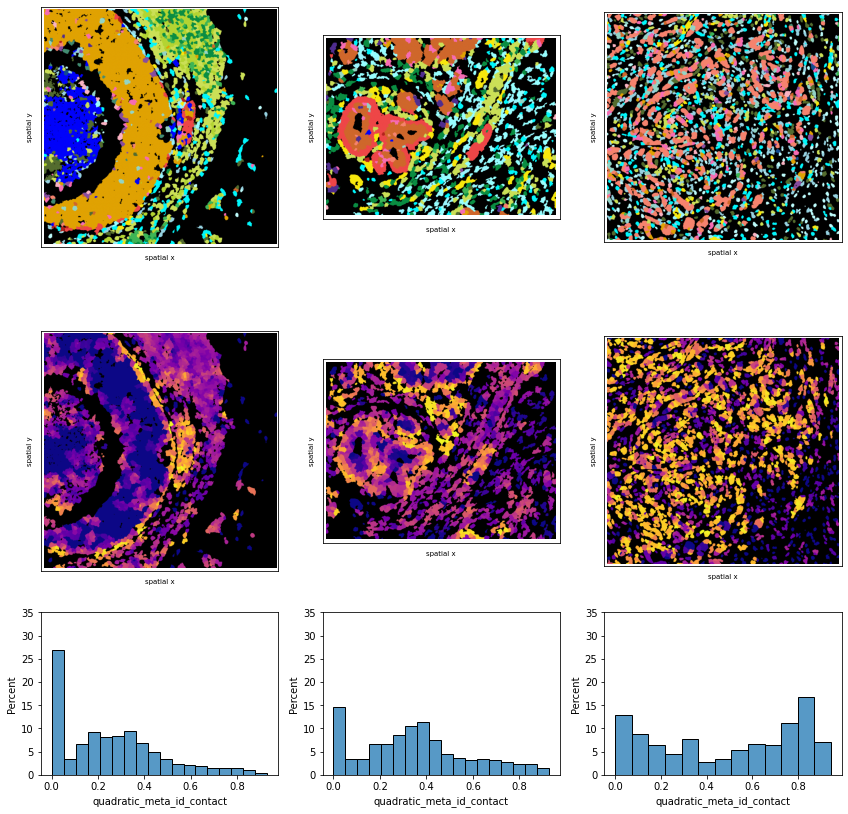

In [19]:
attr = 'quadratic_meta_id_contact'
fig, axs = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={'height_ratios': [2,2,1]})
for axv, spl in zip(axs.T, cores_entropy):
    ath.pl.spatial(so, spl, 'meta_id', mode='mask', ax=axv[0], cbar=False, background_color='black')
    axv[0].set_title('')
    
    ath.pl.spatial(so, spl, attr, mode='mask', ax=axv[1], cbar=False, background_color='black')
    axv[1].set_title('')
    
    sns.histplot(so.obs[spl][attr], ax=axv[2], stat='percent')
    axv[2].set_ylim([0,35])

## Infiltration

The infiltration score quantifies the degree to which a certain cell phenotype has penetrated among cells of another type. In cancer research, the degree to which immune cells infiltrate the tumor tissue is of particular interest and one can distinguish between cold and hot tumors based on if they include few or many immune cells, respectively.

In [20]:
for spl in cores_infiltration:
    ath.neigh.infiltration(so, spl, 'cell_type', graph_key='radius', add_key='infiltration_radius')
    
so.spl.loc[cores_infiltration].infiltration_radius

core
SP43_116_X3Y4     0.173355
SP41_220_X10Y5    0.197151
SP41_191_X15Y7    2.054326
Name: infiltration_radius, dtype: float64

In [21]:
for spl in cores_infiltration[:1]:
    ath.neigh.infiltration(so, spl, 'cell_type', graph_key='radius', local=True)

100%|██████████████████████████████████████████████████████████| 6069/6069 [00:43<00:00, 138.10it/s]
/usr/local/Caskroom/miniconda/base/envs/test-athena/lib/python3.8/site-packages/athena/neighborhood/estimators.py:118: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  so.obs[spl] = pd.concat((so.obs[spl], res), 1)


In [22]:
so.obs[spl].loc[:, 'infiltration_radius'].head()

1     5.00
2     7.00
3     6.75
4    12.00
5      NaN
Name: infiltration_radius, dtype: float64

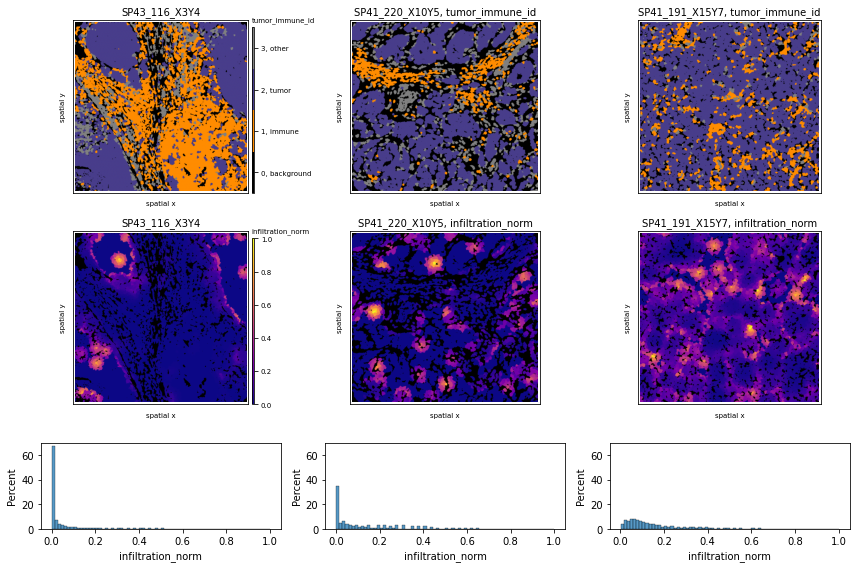

In [23]:
fig, axs = plt.subplots(3,3, figsize=(12, 8), gridspec_kw={'height_ratios': [2,2,1]})
pl_cbar = True
for axv, spl in zip(axs.T, cores_infiltration):
    # ath.pl.spatial(so, spl, 'immune_type_id', mode='mask', ax=axv[0], background_color='black')
    ath.pl.spatial(so, spl, 'tumor_immune_id', mode='mask', ax=axv[0], background_color='black', cbar=pl_cbar)
    
    x = so.obs[spl].infiltration_radius.copy()
    so.obs[spl]['infiltration_norm'] = x / x.max()
    sns.histplot(so.obs[spl]['infiltration_norm'], stat='percent', ax=axv[2], bins=70)
    axv[2].set_ylim(0,70)

    so.obs[spl]['infiltration_norm'].fillna(0, inplace=True)
    ath.pl.spatial(so, spl, 'infiltration_norm', mode='mask', ax=axv[1], background_color='black', cbar=pl_cbar)
    pl_cbar = False

# Setting up the Analysis

## Creating a spatialOmics instance
This section demonstrates how one can construct a `spatialOmics` instance from raw data

### From Raw Data

In [24]:
import urllib.request
import tarfile
import tempfile
from skimage import io
import os
from spatialOmics import SpatialOmics

# url from which we download example images
url = 'https://ndownloader.figshare.com/files/29006556'
filehandle, _ = urllib.request.urlretrieve(url)

# extract images from tar archive
fimg = 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_122_166_X15Y4_231_a0_full.tiff'
fmask = 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_122_166_X15Y4_231_a0_full_maks.tiff'
fmeta = 'meta_data.csv'
root = 'spatialOmics-tutorial'


so1 = SpatialOmics()
with tempfile.TemporaryDirectory() as tmpdir:
    with tarfile.open(filehandle, 'r:gz') as tar:
        tar.extractall(tmpdir)
        
        # load image and segmentation mask
        img = io.imread(os.path.join(tmpdir, root, fimg))
        mask = io.imread(os.path.join(tmpdir, root, fmask))
        
        # load sample meta data
        pmeta = os.path.join(tmpdir, root, fmeta)
        meta = pd.read_csv(pmeta).set_index('core')
        
        # set sample data of spatialOmics
        so1.spl = meta.loc[meta.filename_fullstack == fimg]  # only include the meta data for the current image
        spl = so1.spl.index[0]
        
        # add high-dimensional tiff image
        pimg = os.path.join(tmpdir, root, fimg)
        so1.add_image(spl, pimg)

        # add segmentation mask
        pmask = os.path.join(tmpdir, root, fmask)
        so1.add_mask(spl, 'cellmasks', pmask)
        
        # initialise X, obs
        ids = np.unique(so1.masks[spl]['cellmasks'])
        ids = ids[ids != 0]
        so1.X[spl] = pd.DataFrame(index=ids)
        so1.obs[spl] = pd.DataFrame(index=ids)

so1


SpatialOmics object with n_obs 3066
    X: 1, (3066, 3066) x (0, 0)
    spl: 1, ['pid', 'grade', 'location', 'tumor_size', 'gender', 'age', 'disease_status', 'ER_status', 'PR_status', 'filename_fullstack', 'height', 'width', 'area', 'subtype', 'clinical_type', 'cohort', 'file_fullstack', 'file_cellmask', 'file_tumor_stroma_mask']
    obs: 1, set()
    var: 0, set()
    G: 0, set()
    masks: 1, {'cellmasks'}
    images: 1

/usr/local/Caskroom/miniconda/base/envs/test-athena/lib/python3.8/site-packages/athena/plotting/visualization.py:217: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


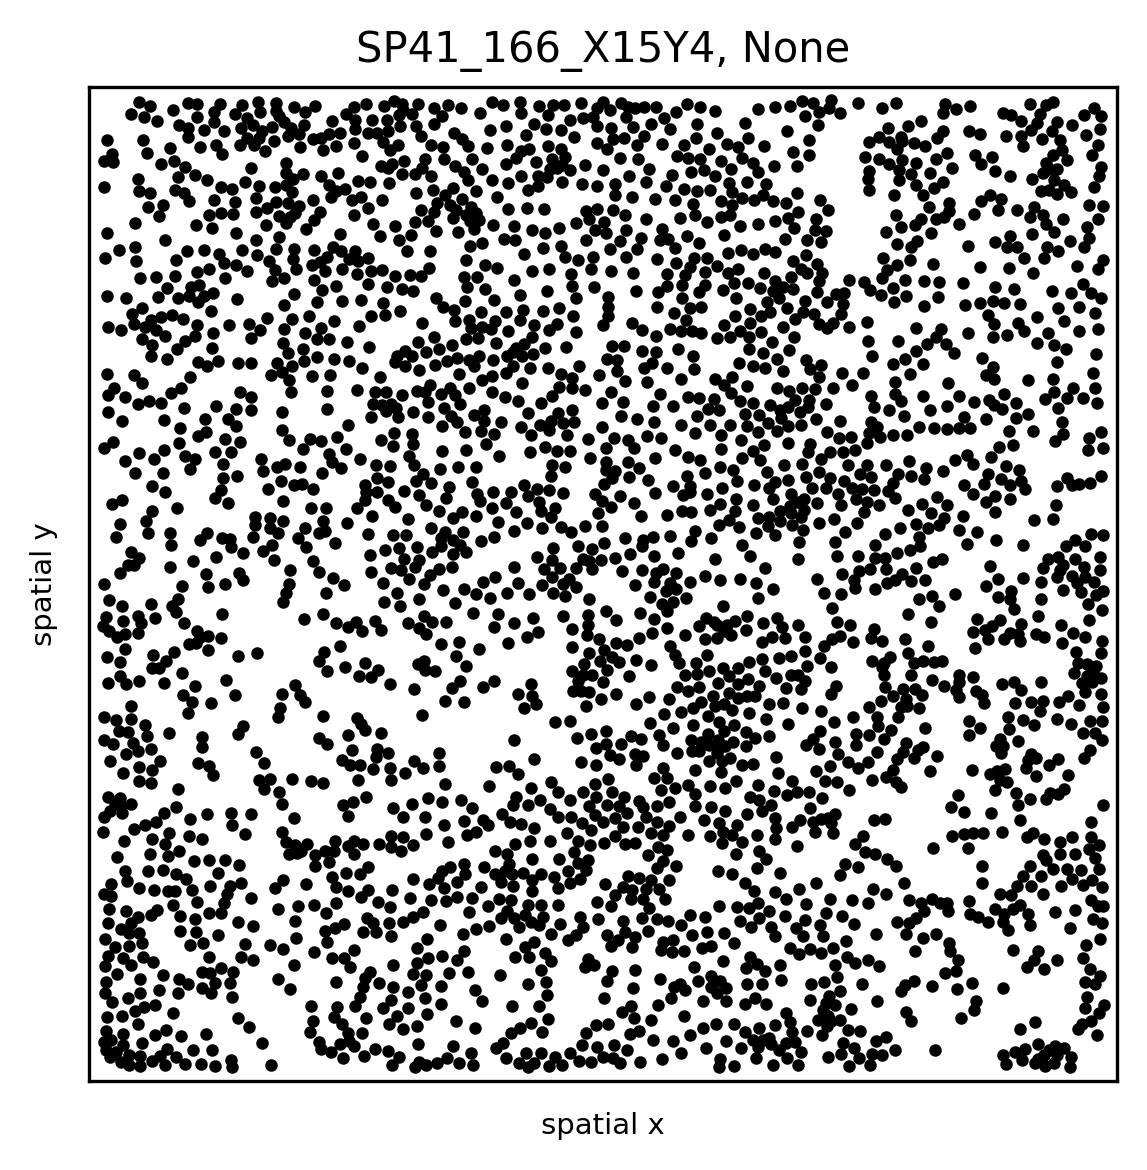

In [25]:
ath.pp.extract_centroids(so1, spl)
ath.pl.spatial(so1, spl, None)

### Extract Single-Cell Expression Values
Based on the cellmask we can extract single cell protein expression values from the image. 

In [26]:
import numpy as np
from tqdm import tqdm

expr = so1.images[spl]
mask = so1.masks[spl]['cellmasks']

ids = np.unique(mask)
ids = ids[ids != 0]

# extract single-cell expression values for each layer in the image
res = []
for i in tqdm(ids):
    res.append(expr[:, mask == i].mean(1))

# add single cell expression values to spatialOmics instance
so1.X[spl] = pd.DataFrame(np.stack(res, axis=0), index=ids)
so1.X[spl].head()

100%|██████████████████████████████████████████████████████████| 3066/3066 [00:04<00:00, 756.82it/s]


0         1         2         3         4         5          6   \
1  504.166809  2.789689  0.932818  5.546103  4.836011  7.478273  13.754079   
2  505.758942  2.674268  0.773134  4.117366  4.382695  5.827538  10.489146   
3  508.826782  1.467071  0.430452  3.453262  3.192524  4.715620   8.948931   
4  504.302216  1.514519  0.465135  2.714404  2.464943  3.109519   6.833097   
5  501.418091  1.511736  0.669417  2.982694  3.212319  4.436403   8.498236   

         7          8         9   ...        42        43        44  \
1  9.304479  11.435987  1.101779  ...  0.114558  0.922130  0.460403   
2  8.184184   6.676378  0.500451  ...  0.069695  1.408488  0.940549   
3  6.917524   5.500190  0.650714  ...  0.087429  0.856952  0.399071   
4  4.575481   5.994712  0.426192  ...  0.057692  0.465808  0.416808   
5  5.890807   4.390930  0.360083  ...  0.069625  0.406875  0.000000   

          45        46        47         48        49        50        51  
1  11.155493  0.821286  7.141858  13.127857  4.487766  0.916052  0.027065  
2  28.769440  1.303585  2.372439   4.156317  4.631183  0.823171  0.038183  
3  21.614906  1.032905  1.630524   3.740691  4.537024  0.664929  0.084000  
4  13.019441  0.625423  1.114288   2.582231  4.727558  0.812923  0.148673  
5   0.066417  0.702208  1.957056   3.781848  4.303611  0.862278  0.105028  

[5 rows x 52 columns]

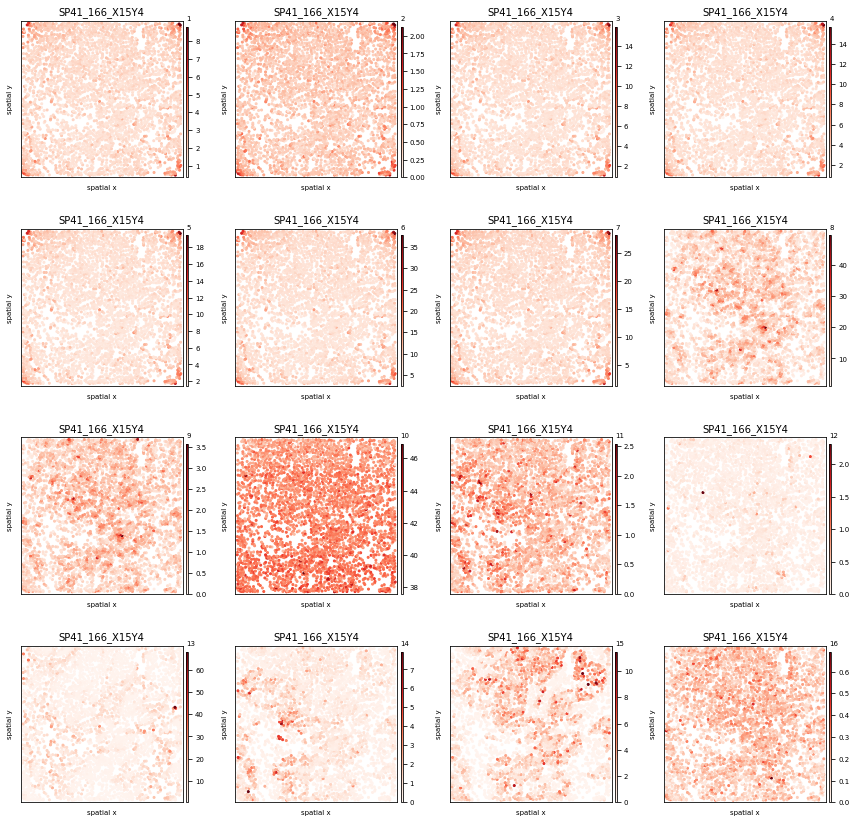

In [27]:
fig, axs = plt.subplots(4,4, figsize=(12,12))
for ax, i in zip(axs.flat, range(1,100)):
    ath.pl.spatial(so1, spl, i, ax=ax)

### From AnnData (2)

In [28]:
!pip install squidpy

Looking in indexes: https://pypi.org/simple, https://eu.artifactory.swg-devops.com/artifactory/api/pypi/res-sysbio-team-chcls-public-pypi-local/simple


In [ ]:
import squidpy as sq
from spatialOmics import SpatialOmics

imc = sq.datasets.imc()
so2 = SpatialOmics.from_annData(imc)
so2

/usr/local/Caskroom/miniconda/base/envs/test-athena/lib/python3.8/site-packages/spatialOmics/spatialOmics.py:344: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  so.obs[sample_name] = pd.concat((so.obs[sample_name], coord), 1)



SpatialOmics object with n_obs 4668
    X: 1, (4668, 4668) x (34, 34)
    spl: 1, []
    obs: 1, {'y', 'sample_id', 'cell type', 'x'}
    var: 1, set()
    G: 0, set()
    masks: 0, set()
    images: 0

In [ ]:
for spl in so2.spl.index:
    so2.add_image(spl, PATH_TO_IMAGE)
    so2.add_mask(spl, 'cellmasks', PATH_TO_MASK)

NameError: name 'PATH_TO_IMAGE' is not defined

## Creating color maps for plotting
Colormaps for attributes can be saved to the `.uns` attribute of the SpatialOmics instance, where it will be accessed by the `.pl` submodules when plotting certain features of the data.
If no colormap is defined, the .pl module uses the default colormap (`so.uns['colormap']['default']`).

In [18]:
# define default colormap
so.uns['cmaps'].update({'default': cm.plasma})

# set up colormaps for meta_id
cmap_paper = np.array([[255, 255, 255], [10, 141, 66], [62, 181, 86], [203, 224, 87],  # 0 1 2 3
                       [84, 108, 47], [180, 212, 50], [23, 101, 54],  # 4 5 6
                       [248, 232, 13], [1, 247, 252], [190, 252, 252],  # 7 8 9
                       [150, 210, 225], [151, 254, 255], [0, 255, 250],  # 10 11 12
                       [154, 244, 253], [19, 76, 144], [0, 2, 251],  # 13 14 15
                       [147, 213, 198], [67, 140, 114], [238, 70, 71],  # 16 17 18
                       [80, 45, 143], [135, 76, 158], [250, 179, 195],  # 19 20 21
                       [246, 108, 179], [207, 103, 43], [224, 162, 2],  # 22 23 24
                       [246, 131, 110], [135, 92, 43], [178, 33, 28]])


# define labels for meta_id
cmap_labels = {0: 'Background',
               1: 'B cells',
               2: 'B and T cells',
               3: 'T cell',
               4: 'Macrophages',
               5: 'T cell',
               6: 'Macrophages',
               7: 'Endothelial',
               8: 'Vimentin Hi',
               9: 'Small circular',
               10: 'Small elongated',
               11: 'Fibronectin Hi',
               12: 'Larger elongated',
               13: 'SMA Hi Vimentin',
               14: 'Hypoxic',
               15: 'Apopotic',
               16: 'Proliferative',
               17: 'p53 EGFR', 
               18: 'Basal CK',
               19: 'CK7 CK hi Cadherin',
               20: 'CK7 CK',
               21: 'Epithelial low',
               22: 'CK low HR low',                            
               23: 'HR hi CK',               
               24: 'CK HR', 
               25: 'HR low CK',                             
               27: 'Myoepithalial',
               26: 'CK low HR hi p53'}

so.uns['cmaps'].update({'meta_id': ListedColormap(cmap_paper / 255)})
so.uns['cmap_labels'].update({'meta_id': cmap_labels})

# cell_type_id colormap
cmap = ['white', 'darkgreen', 'gold', 'steelblue', 'darkred', 'coral']
cmap_labels = {0: 'background', 1: 'immune',  2: 'endothelial', 3: 'stromal', 4: 'tumor', 5: 'myoepithelial'}
cmap = ListedColormap(cmap)

so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

In [19]:
# cell_type_id
cmap = ['white', 'darkgreen', 'gold', 'steelblue', 'darkred', 'coral']
cmap_labels = {0: 'background', 1: 'immune',  2: 'endothelial', 3: 'stromal', 4: 'tumor', 5: 'myoepithelial'}
cmap = ListedColormap(cmap)

so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

In [20]:
# tumorYN
cmap = ['black', 'darkorange', 'darkslateblue', 'grey']
cmap_labels = {0: 'background', 1: 'immune',  2: 'tumor', 3: 'other'}
cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'tumor_immune_id': cmap})
so.uns['cmap_labels'].update({'tumor_immune_id': cmap_labels})

## Pitfalls when working with cell mask maps

- The labels in the cell masks need to be aligned with the index in the `so.obs[spl]` dataframe